# 국민청원 데이터로 청원 카테고리 분류하기

* 청원의 카테고리를 분류해 봅니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(192387, 8)

In [3]:
petitions.describe()

,article_id,answered,votes
count,192387.000000,192387.000000,192387.000000
mean,113937.905035,0.000135,145.026748
std,70999.561497,0.011624,4382.942031
min,21.000000,0.000000,0.000000
25%,49908.500000,0.000000,1.000000
50%,111144.000000,0.000000,3.000000
75%,173456.500000,0.000000,10.000000
max,242902.000000,1.000000,615354.000000


In [4]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 1000) & (petitions['votes'] < 100000)].copy()
df.shape

(1634, 8)

In [5]:
df.describe()

,article_id,answered,votes
count,1634.000000,1634.0,1634.000000
mean,129963.707466,0.0,7595.474296
std,71184.858826,0.0,13000.336596
min,28.000000,0.0,1002.000000
25%,65641.000000,0.0,1551.500000
50%,139767.500000,0.0,2685.500000
75%,188393.000000,0.0,6700.250000
max,242889.000000,0.0,99947.000000


In [6]:
category_count = df['category'].value_counts()
category_count

인권/성평등         204
보건복지           179
육아/교육          170
안전/환경          152
정치개혁           151
문화/예술/체육/언론    127
기타             124
교통/건축/국토       121
행정              77
일자리             77
외교/통일/국방        65
반려동물            62
경제민주화           59
미래              26
성장동력            16
저출산/고령화대책       13
농산어촌            11
Name: category, dtype: int64

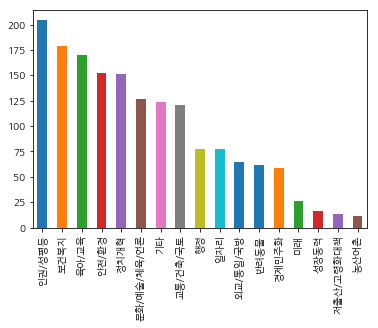

In [7]:
%matplotlib inline 
category_count.plot(kind='bar')

In [8]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [9]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리


In [10]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = df.iloc[0][0]
sample_index

28

In [11]:
sample_title = df['title'][sample_index]
sample_title

'치과위생사 국가고시 날짜 변경 억울합니다'

In [12]:
sample_content = petitions['content'][sample_index]
sample_content

'안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생입니다. 다름이 아니라 너무 억울한\\n일이 생겨  이렇게 글을 적어봅니다. 저희 3학년들은 올해 아주 중요한 시험이  있었습니다.3년동안 힘들게 고생하여 이제곧\\n끝난다.조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을\\n보내주었습니다. 그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다.국시원에서 국가고시 날짜가 변경 되었다.\\n그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다. 그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의 2번 국시를 볼수없다\\n그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년 18년 1월 5일이다 라는것입니다.\\n그 말을  듣고 더욱 이해할수가 없었습니다. 먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도\\n없고 그공지글도 그냥 통보였습니다. 국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게\\n말이 됩니까? 고등학생들이 보는 모의고사,수능도 이런식으로  변경 하지않습니다.  통보로 날짜를 변경하는건  저희\\n에비 의료기사들을 무시하는걸로 보입니다. 저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다. 하지만 저는  그러지 못할꺼같습니다.  아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다.\\n17년 12월16일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들 입니다. 공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요? 먼저 그날의 시험을 보기로 한 학생들은 저희입니다\\n왜 갑자기 저희가 양보해야하고  피해를봐야합니까?  저희국시 앞으로 4달남은상

# 전처리 하기 

In [13]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [14]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [15]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [16]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [17]:
pre_sample_content

'안녕하십니까  대통령님 간단하게 제소개 부터 하겠습니다  치위생과  학년 학생입니다  다름이 아니라 너무 억울한 일이 생겨  이렇게 글을 적어봅니다  저희  학년들은 올해 아주 중요한 시험이  있었습니다  년동안 힘들게 고생하여 이제곧 끝난다 조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을 보내주었습니다  그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다 국시원에서 국가고시 날짜가 변경 되었다  그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다  그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의  번 국시를 볼수없다 그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년   년   일이다 라는것입니다  말을  듣고 더욱 이해할수가 없었습니다  먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도 없고 그공지글도 그냥 통보였습니다  국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게 말이 됩니까  고등학생들이 보는 모의고사 수능도 이런식으로  변경 하지않습니다   통보로 날짜를 변경하는건  저희 에비 의료기사들을 무시하는걸로 보입니다  저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다  하지만  그러지 못할꺼같습니다   아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다    년    일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들  공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요  먼저 그날의 시험을 보기로 학생들은 저희입니다 갑자기 저희가 양보해야하고  피해를봐야합니까   저희국시 앞으로  달남은상태였고 지금 학생들이 지쳐지만   월만 참으면 된다 라는 생각으로  견딘 학

In [18]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 173 ms, sys: 3.87 ms, total: 176 ms
Wall time: 179 ms


In [19]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 321 ms, sys: 5.09 ms, total: 327 ms
Wall time: 329 ms


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [20]:
df = df.reindex()

In [21]:
df.shape

(1634, 11)

In [22]:
split_count = int(df.shape[0] * 0.7)
split_count

1143

In [23]:
df_train = df[:split_count].copy()
df_train.shape

(1143, 11)

In [24]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [25]:
df_test = df[split_count:].copy()
df_test.shape

(491, 11)

In [26]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
148387,178819,2018-03-28,2018-04-27,0,3270,기타,실적압박으로 인한 자살 기억하시는지요...현재도 진행형입니다..,안녕하십니까.\nkt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다\n알고계실지...,기타,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...
148492,178954,2018-03-28,2018-04-27,0,2030,안전/환경,김부겸 행정안전부 장관님께 정확한 사실관계 확인 부탁드립니다.,"道 기획조정실, 일방적 사업 축소 반발 일자 신규채용 관련 감사도\n소방관들 “업무...",안전/환경,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...
148635,179146,2018-03-29,2018-04-28,0,16216,보건복지,저희 엄마 사망의 진실을 알려주십시오,저는 며칠 전 병원에서 엄마를 잃었습니다.\n그런데 병원측의 너무나 어처구니 없는 ...,보건복지,저는 며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 없는 대...,며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 대처로 억울하...
148648,179162,2018-03-29,2018-04-28,0,6698,육아/교육,총신대 사태의 희생양이된 학생들을 전과자로 만들어서는 결코 안됩니다.,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,육아/교육,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 없어...
148763,179317,2018-03-29,2018-04-28,0,1018,교통/건축/국토,무책임한 집주인 및 임대사업자에 대한 대책을 마련해주세요,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,교통/건축/국토,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,요즘 깡통전세 전세 세입자의 전재산으로 볼 전세 보증금을 보장 받지 못하는 사례가 ...


## 카테고리 

In [27]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)

,category_x,category_y
보건복지,134,0.117235
인권/성평등,127,0.111111
육아/교육,124,0.108486
안전/환경,105,0.091864
정치개혁,98,0.085739
문화/예술/체육/언론,95,0.083115
교통/건축/국토,86,0.075241
기타,80,0.069991
일자리,59,0.051619
행정,55,0.048119


In [28]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)

,category_x,category_y
인권/성평등,77,0.156823
정치개혁,53,0.107943
안전/환경,47,0.095723
육아/교육,46,0.093686
보건복지,45,0.091650
기타,44,0.089613
교통/건축/국토,35,0.071283
문화/예술/체육/언론,32,0.065173
경제민주화,24,0.048880
행정,22,0.044807


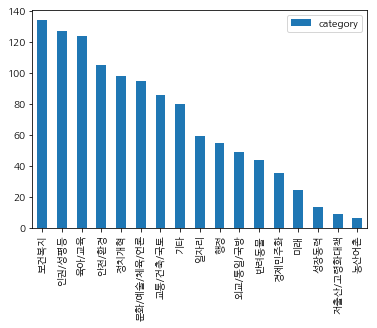

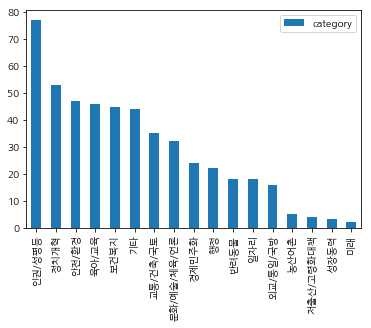

In [29]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [31]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 3.13 s, sys: 111 ms, total: 3.24 s
Wall time: 3.26 s


In [32]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 1.47 s, sys: 55 ms, total: 1.53 s
Wall time: 1.64 s


In [33]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'and',
 'article',
 'as',
 'co',
 'co kr',
 'co kr news',
 'com',
 'com main',
 'com main read']

In [34]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,and,article,as,co,co kr,co kr news,com,com main,com main read,...,효과를,후에,훨씬,휴게시간,힘든,힘들게,힘들어,힘없는,힘을,힘이
0,39,28,59,46,46,19,102,96,47,190,...,41,33,68,29,20,18,21,17,42,24


In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [36]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 4.84 ms, sys: 2.46 ms, total: 7.3 ms
Wall time: 7.4 ms


In [37]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 3.28 ms, sys: 1.97 ms, total: 5.25 ms
Wall time: 3.25 ms


In [38]:
test_feature_tfidf.shape

(491, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [39]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [40]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 1.49 s, sys: 46.9 ms, total: 1.54 s
Wall time: 601 ms


# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면, (feat.애란쌤)
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 76.4 ms, sys: 28.9 ms, total: 105 ms
Wall time: 2.12 s


array([0.42358079, 0.36681223, 0.40174672, 0.37280702, 0.34210526])

In [42]:
round(np.mean(score)*100,2)

38.14

# 예측

In [43]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['문화/예술/체육/언론', '보건복지', '안전/환경'], dtype=object)

In [44]:
y_pred.shape

(491,)

In [45]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,문화/예술/체육/언론
1,보건복지
2,안전/환경
3,육아/교육
4,육아/교육


In [46]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

보건복지           95
육아/교육          87
인권/성평등         69
반려동물           56
안전/환경          46
기타             30
정치개혁           26
외교/통일/국방       24
교통/건축/국토       23
문화/예술/체육/언론    18
경제민주화           8
일자리             6
행정              3
Name: category_pred, dtype: int64

In [47]:
df_test['category_pred'] = y_pred

In [48]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
148387,178819,2018-03-28,2018-04-27,0,3270,기타,실적압박으로 인한 자살 기억하시는지요...현재도 진행형입니다..,안녕하십니까.\nkt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다\n알고계실지...,문화/예술/체육/언론,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,0
148492,178954,2018-03-28,2018-04-27,0,2030,안전/환경,김부겸 행정안전부 장관님께 정확한 사실관계 확인 부탁드립니다.,"道 기획조정실, 일방적 사업 축소 반발 일자 신규채용 관련 감사도\n소방관들 “업무...",보건복지,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,0
148635,179146,2018-03-29,2018-04-28,0,16216,보건복지,저희 엄마 사망의 진실을 알려주십시오,저는 며칠 전 병원에서 엄마를 잃었습니다.\n그런데 병원측의 너무나 어처구니 없는 ...,안전/환경,저는 며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 없는 대...,며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 대처로 억울하...,0
148648,179162,2018-03-29,2018-04-28,0,6698,육아/교육,총신대 사태의 희생양이된 학생들을 전과자로 만들어서는 결코 안됩니다.,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,육아/교육,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 없어...,1
148763,179317,2018-03-29,2018-04-28,0,1018,교통/건축/국토,무책임한 집주인 및 임대사업자에 대한 대책을 마련해주세요,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,육아/교육,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,요즘 깡통전세 전세 세입자의 전재산으로 볼 전세 보증금을 보장 받지 못하는 사례가 ...,0


In [49]:
# 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    423
1     68
Name: pred_diff, dtype: int64

In [50]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

전체 491건의 데이터 중 68건 예측


In [51]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 13.849287169042771


In [52]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
148648,179162,2018-03-29,2018-04-28,0,6698,육아/교육,총신대 사태의 희생양이된 학생들을 전과자로 만들어서는 결코 안됩니다.,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,육아/교육,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 없어...,1
149877,180668,2018-03-30,2018-04-29,0,1817,육아/교육,4차 산업혁명 시대에 맞게 학교 우유급식 신청을 앱이나 컴퓨터로 간편하게 하고 가정...,4차 산업혁명의 시대에 학교에서 수십 년 동안 가장 변하지 않는 것이 있다면 우유급...,육아/교육,차 산업혁명의 시대에 학교에서 수십 년 동안 가장 변하지 않는 것이 있다면 우유급...,차 산업혁명의 시대에 학교에서 수십 년 동안 가장 변하지 않는 것이 있다면 우유급...,1
150294,181201,2018-03-30,2018-04-29,0,13992,기타,이번에 순직한 예비소방관이 순직처리 안될수도 있다는 얘기가 있습니다.,이번에 순직한 예비소방관이 순직처리 안될수도 있다는 얘기가 있습니다.\n예비 소방관...,기타,이번에 순직한 예비소방관이 순직처리 안될수도 있다는 얘기가 있습니다 예비 소방관이...,이번에 순직한 예비소방관이 순직처리 안될수도 있다는 얘기가 예비 소방관이더라도 공...,1
150358,181276,2018-03-30,2018-04-29,0,1936,육아/교육,2019학년도부터 정시확대 요구합니다,올해 수능을 준비하는 학생입니다.지금 2020학년도부터 정시확대를 하도록 교육부가 ...,육아/교육,올해 수능을 준비하는 학생입니다 지금 학년도부터 정시확대를 하도록 교육부가 ...,올해 수능을 준비하는 학생입니다 지금 학년도부터 정시확대를 하도록 교육부가 ...,1
150748,181741,2018-03-31,2018-04-30,0,3717,경제민주화,공매도 15억 이상시 대주주 요건 해당 25프로 세금 부과,공매도 15억 이상 하는 자들이 대주주 요건에 해당되는지 검토해야 한다\n만일 대주...,경제민주화,공매도 억 이상 하는 자들이 대주주 요건에 해당되는지 검토해야 한다 만일 대주주...,공매도 억 이상 자들이 대주주 요건에 해당되는지 검토해야 만일 대주주에 해당된다...,1


In [53]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
148387,178819,2018-03-28,2018-04-27,0,3270,기타,실적압박으로 인한 자살 기억하시는지요...현재도 진행형입니다..,안녕하십니까.\nkt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다\n알고계실지...,문화/예술/체육/언론,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,0
148492,178954,2018-03-28,2018-04-27,0,2030,안전/환경,김부겸 행정안전부 장관님께 정확한 사실관계 확인 부탁드립니다.,"道 기획조정실, 일방적 사업 축소 반발 일자 신규채용 관련 감사도\n소방관들 “업무...",보건복지,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,0
148635,179146,2018-03-29,2018-04-28,0,16216,보건복지,저희 엄마 사망의 진실을 알려주십시오,저는 며칠 전 병원에서 엄마를 잃었습니다.\n그런데 병원측의 너무나 어처구니 없는 ...,안전/환경,저는 며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 없는 대...,며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 대처로 억울하...,0
148763,179317,2018-03-29,2018-04-28,0,1018,교통/건축/국토,무책임한 집주인 및 임대사업자에 대한 대책을 마련해주세요,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,육아/교육,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,요즘 깡통전세 전세 세입자의 전재산으로 볼 전세 보증금을 보장 받지 못하는 사례가 ...,0
148854,179421,2018-03-29,2018-04-28,0,2052,반려동물,동물보호법 강화 부탁드립니다,"""한 나라의 위대성과 그 도덕성은 동물들을 다루는 태도로 판단할 수 있다. 나는 나...",육아/교육,한 나라의 위대성과 그 도덕성은 동물들을 다루는 태도로 판단할 수 있다 나는 나...,나라의 위대성과 도덕성은 동물들을 다루는 태도로 판단할 있다 나는 나약한 동물일...,0


In [54]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

인권/성평등         64
정치개혁           46
안전/환경          42
보건복지           40
기타             38
교통/건축/국토       35
문화/예술/체육/언론    31
행정             22
육아/교육          20
경제민주화          19
반려동물           18
일자리            18
외교/통일/국방       16
농산어촌            5
저출산/고령화대책       4
성장동력            3
미래              2
Name: category, dtype: int64

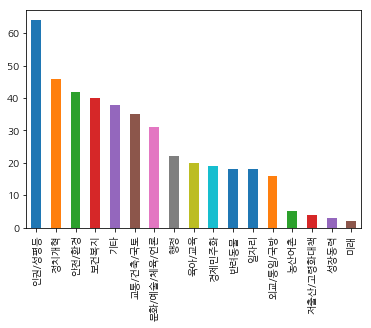

In [55]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [56]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
148387,기타,문화/예술/체육/언론,실적압박으로 인한 자살 기억하시는지요...현재도 진행형입니다..,안녕하십니까.\nkt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다\n알고계실지...
148492,안전/환경,보건복지,김부겸 행정안전부 장관님께 정확한 사실관계 확인 부탁드립니다.,"道 기획조정실, 일방적 사업 축소 반발 일자 신규채용 관련 감사도\n소방관들 “업무..."
148635,보건복지,안전/환경,저희 엄마 사망의 진실을 알려주십시오,저는 며칠 전 병원에서 엄마를 잃었습니다.\n그런데 병원측의 너무나 어처구니 없는 ...
148763,교통/건축/국토,육아/교육,무책임한 집주인 및 임대사업자에 대한 대책을 마련해주세요,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...
148854,반려동물,육아/교육,동물보호법 강화 부탁드립니다,"""한 나라의 위대성과 그 도덕성은 동물들을 다루는 태도로 판단할 수 있다. 나는 나..."
148958,안전/환경,외교/통일/국방,세월호 관련 청문회 위증한 조여옥 대위 징계바랍니다~,청문회때 실망했습니다.\n조여옥대위는 징계해야 마땅합니다.
148990,보건복지,교통/건축/국토,중국인들 건강보험 악용 막아주세요.,중국인들이 건강보험 악용하고 돌아가는 경우가 많은데 대책을 빨리 안세우고 뭐하는 ...
148999,문화/예술/체육/언론,기타,블랙하우스 폐지 반대,블랙하우스 폐지를 외치는자들에게 경종을 울리기 위해 이글을 씁니다\n고 노무현 대통...
149001,안전/환경,보건복지,"미세먼지,초미세먼지 WHO 기준으로 관리(기록,예보,보도 등) 의무화 해주세요.",포털싸이트와 공중파 포함 방송사들의\n미세먼지 기준의 예보를 WHO 미세먼지 기준으...
149190,정치개혁,보건복지,황전원 특조위원 박탈을 청원합니다,숨겨진 세월호 7시간에 대하여 조사결과가 나오고 있는 이 시점에서\n오늘 하루 또 ...


## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [57]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
148387,기타,문화/예술/체육/언론,실적압박으로 인한 자살 기억하시는지요...현재도 진행형입니다..,안녕하십니까.\nkt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다\n알고계실지...
149650,기타,반려동물,조여옥 이슬비 대위를 수사하여 주시기 바랍니다,아직도 청문회 장면이 생생합니다\n뻔한 거짓말로 눈하나 까딱않고 위증을 하던 증인~...
153495,기타,보건복지,부모 같지 않은 부모들이 자식 주소지 조회 못 하게 해주세요,가정 폭력 소명하지 않아도 부모 같지 않은 부모들이 자식 주소지 조회 못 하게 해주...
155041,기타,교통/건축/국토,제주도 24개월 아이 성폭행 사건 재조사를 부탁드립니다,https://www1.president.go.kr/petitions/187544?...
155272,기타,육아/교육,삼성 이재용일가와 삼성증권 처벌과 대한민국 사법부의 개혁을 요구합니다,"'승계작업' 존재는 부정... '삼성'만 웃었습니다\n김 재판장은 ""승계작업과 관련..."
155681,기타,육아/교육,"동물들이 고통받는 '체험형 실내 동물원', 규제할 방안을 마련해주세요.",요즘 ‘체험형 실내 동물원’이 유행하고 있습니다. 실내에 있기 때문에 이동이 편하고...
157353,기타,보건복지,어버이날 휴일지정 반대합니다,어버이날을 휴일로 지정하여 연휴를 늘리는 것\n반대합니다.\n경제적 부담이 크고 명...
158445,기타,인권/성평등,<<불합리한 식품위생법 개정과 청소년 음주 관용에 대한 청소년 보호법 개정을 위한 ...,<<불합리한 식품위생법 개정과 청소년 음주 관용에 대한 청소년 보호법 개정을 위한 ...
160122,기타,교통/건축/국토,대한항공 조현민 전무의 갑질을 엄중 처벌해야합니다.,대한항공 조현민의 갑질을 엄중 처벌해야합니다.\n지난번 땅콩회항 사건 당시 조현아의...
161075,기타,정치개혁,대한항공 -> 한진항공으로!!,대한은 대한민국을 의미합니다.\n처음 조현아의 땅콩회항 사건 때 실시해야 했습니다....
